# Classifier Notebook
- Run this notebook on Colab. Hardware requirement: 16 GB RAM, 1 Nvidia T4 GPU and 2 CPU's or more

In [35]:
# preset values
# sensor readings per gesture iteration:
reading_count = 30

In [66]:
! pip freeze > requirements_classifier.txt

## Installs

In [62]:
#! pip install micromlgen
#! pip install matplotlib
#! pip install xgboost
#! pip install altair
#! pip install altair_viewer
#! pip install scipy
#! pip install scikit-learn
! pip install -r requirements_classifier.txt

  Preparing metadata (setup.py) ... done
  Created wheel for micromlgen: filename=micromlgen-1.1.28-py3-none-any.whl size=32151 sha256=d75068254702d7194f5129d7150d1c9c4372c007e166f7f11bde9117b23ed3a9
  Stored in directory: /root/.cache/pip/wheels/97/54/64/5d82c310920abe1be0d120313ceb9e12c88f5701f53f6ed248
Successfully built micromlgen


## Imports

In [63]:
#plot imports
import altair as alt
import matplotlib.pyplot as plt

#data processing imports
import pandas as pd
import numpy as np

#model selection, evaluation imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

#model imports
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

#general tool impports
from IPython.display import display
import json
from micromlgen import port



## Load the data

In [38]:
raw_sensor_data = pd.read_csv('raw_data_collection/dummy_data.txt', delimiter = '\t')
raw_sensor_data.head()

,iteration,gesture_code,sensor_1_ax,sensor_1_ay,sensor_1_az,sensor_1_gx,sensor_1_gy,sensor_1_gz,sensor_2_ax,sensor_2_ay,sensor_2_az,sensor_2_gx,sensor_2_gy,sensor_2_gz,onboard_ax,onboard_ay,onboard_az,onboard_gx,onboard_gy,onboard_gz
0,1,0,-0.568682,0.601786,-0.989990,0.197055,-0.552065,-0.506900,0.517654,0.216304,0.587042,-0.507669,-0.000800,-0.071559,-0.960108,-0.253852,0.922974,0.252406,-0.954925,0.239031
1,1,0,-0.391427,0.330051,-0.620048,-0.552683,0.307741,-0.016497,-0.366967,-0.279585,0.647960,0.538679,-0.312164,-0.580059,0.994803,-0.067383,-0.387316,0.516054,-0.819110,0.050148
2,1,0,-0.740103,0.211198,-0.386086,-0.244025,0.508226,-0.406110,0.347150,-0.828099,0.023110,0.296853,-0.658154,0.067692,-0.097333,-0.325989,-0.811631,0.595114,-0.883234,0.242658
3,1,0,-0.999427,-0.852134,-0.657411,-0.303113,-0.039585,-0.869214,0.633957,-0.078813,-0.263636,0.653180,-0.535132,0.970812,-0.499927,0.512283,-0.311292,0.949121,-0.867171,-0.419372
4,1,0,0.081985,0.687038,0.787623,0.529409,0.121664,0.578797,-0.321687,-0.555872,0.265379,0.653142,-0.813891,0.057882,0.080889,0.439695,0.424414,-0.143569,0.094118,0.629934


In [39]:
# Gesture code to gesture label dict
with open('raw_data_collection/dummy_gesture_dict.json', 'r') as json_file:
    gesture_dict = json.load(json_file)
gesture_dict


{'gesture_0': 0,
 'gesture_1': 1,
 'gesture_2': 2,
 'gesture_3': 3,
 'gesture_4': 4}

## EDA

In [40]:
# let's create a groupby generator for future use
visual_group_by = raw_sensor_data.groupby('gesture_code')

# let's see what the data looks like.
print('data description')
display(raw_sensor_data.describe())

# let's observe data for one gesture
print('\n')
for gesture_code, gesture_df in visual_group_by:
    print('gesture_code: ',gesture_code)
    display(gesture_df)
    break

data description


,iteration,gesture_code,sensor_1_ax,sensor_1_ay,sensor_1_az,sensor_1_gx,sensor_1_gy,sensor_1_gz,sensor_2_ax,sensor_2_ay,sensor_2_az,sensor_2_gx,sensor_2_gy,sensor_2_gz,onboard_ax,onboard_ay,onboard_az,onboard_gx,onboard_gy,onboard_gz
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,50.500000,2.000000,-0.001864,0.004479,0.005329,-0.000613,-0.001416,-0.000510,0.000531,-0.003209,-0.006232,-0.000557,-0.002425,-0.001477,0.001479,0.002657,-0.006668,0.005626,-0.001454,-0.000008
std,28.867032,1.414261,0.577221,0.576326,0.577247,0.577554,0.574183,0.574265,0.575715,0.581358,0.579332,0.574870,0.579501,0.576986,0.579999,0.574982,0.580572,0.578561,0.581189,0.577045
min,1.000000,0.000000,-0.999839,-0.999924,-0.999863,-0.999759,-0.999950,-0.999942,-0.999928,-0.999691,-0.999838,-0.999750,-0.999899,-0.999975,-0.999909,-0.999532,-0.999889,-0.999893,-0.999948,-0.999893
25%,25.750000,1.000000,-0.504096,-0.494326,-0.495929,-0.498667,-0.498053,-0.492254,-0.495340,-0.507271,-0.509655,-0.496606,-0.508075,-0.497232,-0.498647,-0.494028,-0.511062,-0.494772,-0.511760,-0.502380
50%,50.500000,2.000000,-0.006790,0.004417,0.005059,-0.004546,0.001979,-0.001914,0.001712,-0.007663,-0.008002,0.003697,-0.000175,-0.005212,0.000425,0.007435,-0.003431,0.007545,-0.000804,0.002703
75%,75.250000,3.000000,0.498208,0.500752,0.502497,0.495454,0.488411,0.490967,0.499199,0.504520,0.494921,0.490747,0.494365,0.498057,0.507271,0.502731,0.497005,0.511933,0.502941,0.499209
max,100.000000,4.000000,0.999553,0.999989,0.999834,0.999989,0.999603,0.999522,0.999893,0.999978,0.999790,0.999973,0.999931,0.999311,0.999868,0.999975,0.999809,0.999729,0.999888,0.999926




gesture_code:  0


,iteration,gesture_code,sensor_1_ax,sensor_1_ay,sensor_1_az,sensor_1_gx,sensor_1_gy,sensor_1_gz,sensor_2_ax,sensor_2_ay,sensor_2_az,sensor_2_gx,sensor_2_gy,sensor_2_gz,onboard_ax,onboard_ay,onboard_az,onboard_gx,onboard_gy,onboard_gz
0,1,0,-0.568682,0.601786,-0.989990,0.197055,-0.552065,-0.506900,0.517654,0.216304,0.587042,-0.507669,-0.000800,-0.071559,-0.960108,-0.253852,0.922974,0.252406,-0.954925,0.239031
1,1,0,-0.391427,0.330051,-0.620048,-0.552683,0.307741,-0.016497,-0.366967,-0.279585,0.647960,0.538679,-0.312164,-0.580059,0.994803,-0.067383,-0.387316,0.516054,-0.819110,0.050148
2,1,0,-0.740103,0.211198,-0.386086,-0.244025,0.508226,-0.406110,0.347150,-0.828099,0.023110,0.296853,-0.658154,0.067692,-0.097333,-0.325989,-0.811631,0.595114,-0.883234,0.242658
3,1,0,-0.999427,-0.852134,-0.657411,-0.303113,-0.039585,-0.869214,0.633957,-0.078813,-0.263636,0.653180,-0.535132,0.970812,-0.499927,0.512283,-0.311292,0.949121,-0.867171,-0.419372
4,1,0,0.081985,0.687038,0.787623,0.529409,0.121664,0.578797,-0.321687,-0.555872,0.265379,0.653142,-0.813891,0.057882,0.080889,0.439695,0.424414,-0.143569,0.094118,0.629934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,100,0,0.465811,-0.851265,0.942199,-0.157092,-0.727413,0.668871,-0.206886,-0.139634,-0.843714,-0.583084,0.284707,-0.757164,-0.832457,0.017848,0.776388,-0.498164,-0.884489,-0.557790
2996,100,0,-0.158455,-0.198884,0.728831,-0.080109,0.728502,-0.860967,0.225576,-0.442818,0.485494,0.713539,0.819395,-0.084409,0.618570,0.006612,0.986746,0.005043,-0.969457,-0.284327
2997,100,0,-0.181225,-0.475268,0.418567,-0.994667,0.724194,0.445853,0.286937,0.064854,0.617370,0.490740,-0.801872,0.839242,0.782571,0.600898,-0.250189,-0.682770,-0.367064,0.898990
2998,100,0,0.892075,0.496608,-0.171846,-0.704878,-0.301848,-0.166955,-0.523227,-0.893116,-0.196512,-0.309296,-0.755408,0.914906,0.907281,0.842877,-0.003173,0.296054,0.439112,0.486486


### lets visualize sensor data for each gesture

In [41]:
# building one altair chart
def build_a_viz(raw_table,x_column_name,y_column_name):
    one_chart = alt.Chart(raw_table).mark_circle().encode(
        x=x_column_name,
        y=y_column_name
    )
    return one_chart

# combining multiple visualizations together
def build_multi_viz(gesture_table):
    gesture_table.drop(['iteration','gesture_code'],axis=1,inplace = True)
    sensor_1_chart_list = []
    sensor_2_chart_list = []
    onboard_chart_list = []
    for a_column in gesture_table.columns:
        one_chart = build_a_viz(gesture_table,'sequence_position',a_column)
        if 'sensor_1' in a_column:
            sensor_1_chart_list.append(one_chart)
        if 'sensor_2' in a_column:
            sensor_2_chart_list.append(one_chart)
        if 'onboard' in a_column:
            onboard_chart_list.append(one_chart)

    return alt.vconcat(*[alt.hconcat(*sensor_1_chart_list),alt.hconcat(*sensor_2_chart_list),alt.hconcat(*onboard_chart_list)])


In [42]:
plot_dict = {}
for gesture, gesture_df in visual_group_by:
    # lets create a repeating sequence from [0,30) for every gesture and iteration
    reset_df = gesture_df.reset_index().astype(float)

    # reading_count is defined in the first block of this notebook
    reset_df['sequence_position'] = (reset_df['index'])%reading_count
    plot = build_multi_viz(reset_df)

    # let's plot
    for gesture_name,gesture_code in gesture_dict.items():
        if gesture_code == gesture:
            plot_dict[gesture_name] = plot

plot_dict

{'gesture_0': alt.VConcatChart(...),
 'gesture_1': alt.VConcatChart(...),
 'gesture_2': alt.VConcatChart(...),
 'gesture_3': alt.VConcatChart(...),
 'gesture_4': alt.VConcatChart(...)}

In [43]:
# letssee one of these plots
plot_dict['gesture_1']

alt.VConcatChart(...)

## Feature Development

We are creating features that describe the distribution of the sensor data for every iteration of every gesture

In [44]:
# the features we are interested in:
def build_features(series):
    mean_value = series.mean()
    std_deviation = series.std()
    skewness = series.skew()
    kurtosis_value = series.kurtosis()
    minimum = min(series)
    maximum = max(series)
    return mean_value, std_deviation, skewness, kurtosis_value, minimum, maximum

# function that creates a dict for all features
def feature_pipeline(output_dict,one_gesture_df,key_columns, gesture_key):
    features_list = ['mean_value', 'std_deviation', 'skewness', 'kurtosis_value', 'minimum', 'maximum']

    # if output dict is empty then we create key value pairs wherein the value is an empty list
    if len(output_dict) == 0:
        for sensor_column in key_columns:
            for a_feature in features_list:
                output_dict[sensor_column + '_' + a_feature] = []
        output_dict['gesture_label'] = []

    # for every column, we create the features in features_list and add it to the dict
    for sensor_column in key_columns:
        mean_value, std_deviation, skewness, kurtosis_value, minimum, maximum = build_features(one_gesture_df[sensor_column])
        output_dict[sensor_column + '_' + 'mean_value'].append(mean_value)
        output_dict[sensor_column + '_' + 'std_deviation'].append(std_deviation)
        output_dict[sensor_column + '_' + 'skewness'].append(skewness)
        output_dict[sensor_column + '_' + 'kurtosis_value'].append(kurtosis_value)
        output_dict[sensor_column + '_' + 'minimum'].append(minimum)
        output_dict[sensor_column + '_' + 'maximum'].append(maximum)

    # here we are inputing our target variable
    output_dict['gesture_label'].append(gesture_key)

    return output_dict

In [45]:
#pre set variables
raw_data_columns = ['sensor_1_ax','sensor_1_ay','sensor_1_az','sensor_1_gx','sensor_1_gy','sensor_1_gz','sensor_2_ax','sensor_2_ay','sensor_2_az','sensor_2_gx','sensor_2_gy','sensor_2_gz','onboard_ax','onboard_ay','onboard_az','onboard_gx','onboard_gy','onboard_gz']
output_dict = {}

#lets build feature dict
for (gesture_code,gesture_iteration), gesture_df in raw_sensor_data.groupby(['gesture_code','iteration']):
    output_dict = feature_pipeline(output_dict,gesture_df,raw_data_columns, gesture_code)

#let's convert dict to df
feature_df = pd.DataFrame(output_dict)
feature_df

,sensor_1_ax_mean_value,sensor_1_ax_std_deviation,sensor_1_ax_skewness,sensor_1_ax_kurtosis_value,sensor_1_ax_minimum,sensor_1_ax_maximum,sensor_1_ay_mean_value,sensor_1_ay_std_deviation,sensor_1_ay_skewness,sensor_1_ay_kurtosis_value,...,onboard_gy_kurtosis_value,onboard_gy_minimum,onboard_gy_maximum,onboard_gz_mean_value,onboard_gz_std_deviation,onboard_gz_skewness,onboard_gz_kurtosis_value,onboard_gz_minimum,onboard_gz_maximum,gesture_label
0,-0.026647,0.610323,0.106502,-1.273778,-0.999427,0.928179,-0.023505,0.510183,0.001857,-0.727641,...,-1.385951,-0.954925,0.855514,0.052517,0.529002,-0.228312,-0.919517,-0.926069,0.954346,0
1,-0.031825,0.599033,-0.114761,-1.196760,-0.973571,0.943315,0.015403,0.650602,-0.004613,-1.307622,...,-1.452857,-0.955060,0.832735,0.043303,0.662975,0.078587,-1.424091,-0.965818,0.995897,0
2,-0.153172,0.515311,0.132440,-0.786817,-0.974057,0.896683,-0.004944,0.567864,-0.045879,-1.314496,...,-1.153484,-0.966015,0.955879,0.107590,0.564866,-0.309895,-0.777440,-0.949301,0.996642,0
3,0.172065,0.520029,-0.573690,-0.793602,-0.885250,0.889159,0.132360,0.695927,-0.428493,-1.252043,...,-1.084927,-0.922597,0.988326,-0.084210,0.546412,-0.070780,-1.345497,-0.908209,0.857736,0
4,0.065646,0.625125,-0.342119,-1.299513,-0.983090,0.953832,-0.066138,0.587796,0.002009,-1.101091,...,-1.011951,-0.917429,0.901324,-0.002951,0.553714,-0.122292,-1.290628,-0.862620,0.880563,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.071222,0.547228,-0.324178,-0.824135,-0.995523,0.893847,0.056310,0.492024,0.057180,-0.507285,...,-0.750300,-0.979152,0.976233,-0.003218,0.623890,0.098743,-1.361591,-0.919590,0.995338,4
496,-0.135211,0.537547,0.421355,-0.849658,-0.861603,0.973461,0.014132,0.530890,0.077764,-0.714252,...,-0.232306,-0.983261,0.631773,0.083616,0.570863,-0.161374,-1.276150,-0.977102,0.920520,4
497,-0.197601,0.638307,0.590177,-0.818405,-0.995807,0.975776,-0.042242,0.592873,0.018796,-1.317707,...,-1.045124,-0.961110,0.947888,0.019474,0.643288,-0.269548,-1.517081,-0.952978,0.901973,4
498,0.158985,0.459125,-0.447043,-0.121760,-0.869808,0.947849,-0.078910,0.554449,0.139902,-1.023845,...,-0.998725,-0.971920,0.943215,-0.099553,0.628110,0.149334,-1.301038,-0.997471,0.893515,4


## Train / Test Split

In [46]:
X_raw = feature_df.drop('gesture_label',axis=1)
y_raw = feature_df['gesture_label']

X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.3, random_state=0)


## Model Building Random Forest Classifier

In [49]:
rfc_model = RandomForestClassifier()

# the parameter grid
rfc_param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [5,10,15,20,25],
    'min_samples_split': [2, 5, 10],
    'n_jobs' : [-1]
}

# GridSearchCV for RFC
rfc_grid_search = GridSearchCV(rfc_model, rfc_param_grid, cv=5, n_jobs = -1, verbose = 1)
rfc_grid_search.fit(X_train, y_train)

# top RFC model and its parameters
best_rfc_model = rfc_grid_search.best_estimator_
best_rfc_params = rfc_grid_search.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [50]:
#XGBClassifier model
xgb_model = XGBClassifier(tree_method='gpu_hist')

# the parameter grid
xgb_param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [5,10,15,20,25],
    'learning_rate': [0.01, 0.1, 0.3],
}

# GridSearchCV for XGBClassifier
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, verbose = 1)
xgb_grid_search.fit(X_train, y_train)

# top XGBClassifier model and its parameters
best_xgb_model = xgb_grid_search.best_estimator_
best_xgb_params = xgb_grid_search.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [51]:
# Print the best parameters for each model
print("Best parameters for RandomForestClassifier:", best_rfc_params)
print("Best parameters for XGBClassifier:", best_xgb_params)

Best parameters for RandomForestClassifier: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}
Best parameters for XGBClassifier: {'learning_rate': 0.3, 'max_depth': 20, 'n_estimators': 250}


## Let's build confusion matrixes for both top models

In [57]:
def make_confusion_matrix(model,model_name,Xtest = X_test,Ytest = y_test,df = feature_df):
  # start by making predictions on the test set
  y_pred = model.predict(Xtest)

# let's initialize the confusion matrix
  cm = confusion_matrix(Ytest, y_pred)

# now we build the confusion matrix
  classes = np.array(df['gesture_label'].unique())
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  disp.plot(cmap=plt.cm.Blues)
  plt.title('Confusion Matrix for '+model_name)
  return plt

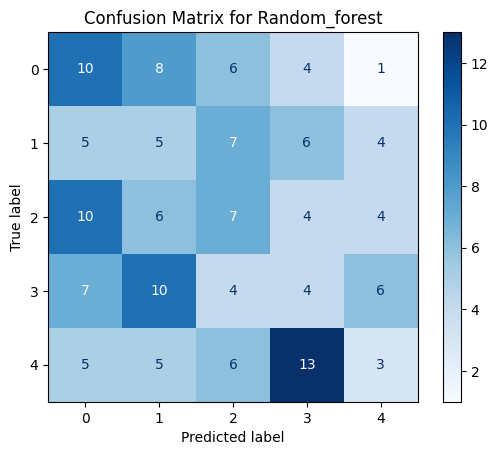

In [53]:
random_forest_plot = make_confusion_matrix(best_rfc_model,'Random_forest')
random_forest_plot.show()

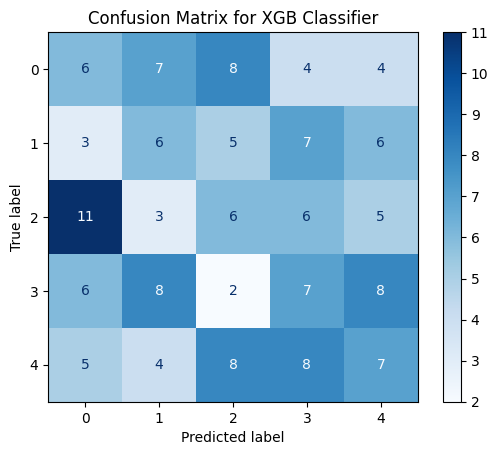

In [54]:
xgb_plot = make_confusion_matrix(best_xgb_model,'XGB Classifier')
xgb_plot.show()

## Let's compare their performance

In [55]:
def evaluate_model(model,model_name, Xtest = X_test,Ytest = y_test):
    y_pred = model.predict(X_test)

    # Build the metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    y_pred_proba = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    # Create a dictionary to store the metrics
    metrics_dict = {
        'model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'AUC': auc
    }

    return metrics_dict


In [56]:
rfc_dict = evaluate_model(best_rfc_model,'RandomForestClassifier')
xgb_dict = evaluate_model(best_xgb_model,'XGBClassifier')
evaluation_df = pd.DataFrame([rfc_dict,xgb_dict])
evaluation_df

,model,Accuracy,Precision,Recall,AUC
0,RandomForestClassifier,0.193333,0.189167,0.193333,0.529274
1,XGBClassifier,0.213333,0.213736,0.213333,0.530105


## Save model for arduino

In [65]:
# we have created two top models from rfc and xgbClassifier.
# best_rfc_model , best_xgb_model

#let's save the top performing model

with open('best_rfc_model.h', 'w') as file:
        file.write(port(best_rfc_model))

with open('best_xgb_model.h', 'w') as file:
        file.write(port(best_xgb_model))